# **Abstract**


In this notebook, the author delves into the construction of neural networks capable of identifying digits from the MNIST dataset, a cornerstone in the field of computer vision known for its extensive collection of handwritten digit images. While numerous deep learning platforms offer convenient APIs for accessing MNIST and similar datasets, these tools can sometimes veil the intricacies involved in data preparation for deep learning models.

The emphasis here is on manipulating real-world data into a structure that is comprehensible by deep learning platforms. The narrative covers various methodologies for processing MNIST data to be compatible with deep learning tools like PyTorch or TensorFlow. This includes steps such as adjusting pixel values through scaling or normalization, transforming images into tensor or array formats, and segmenting the data into sets for training and validation.

Furthermore, the notebook presents tangible examples to illustrate the process of readying MNIST data for use in a deep learning model, employing diverse strategies. This serves to enhance the reader’s comprehension of handling real-world data, aiming to equip them with the knowledge to effectively prepare a dataset for training within a deep learning environment.

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tmnist-alphabet-94-characters:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1564532%2F2830968%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T213516Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcb8e44fd3676e87971d7cc7cb375303bb87ea94ed6df9f3f744e9368829e283a903f5ad48b5535db17583ebf95426916361ba686255c52f647836498f6491dc147f6ccceb7cd80bb8287d09e2718f2bfb88b3862b7153d58cc8d125bb770135dbf6d5e9112ba89cfa29197ce89b07921a7b89aee3e18b2df132d52a51ae2991078cfec041fcfe913ca52e21113a6b56d635f6bb7925c26d64c37391bbbb1797635157a60c9c58e824c0850810f16f087fb65fe9216612b2c81d22da1dd30897f9d17117b1357ab7614c0a764fb4de9c32ef514b820455f470013855bc353ec4b13ed0fea67d02721d64c31d61010c191341d02faa5e5016146686917b2d1e84c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 88850214 bytes downloaded
Downloaded and uncompressed: tmnist-alphabet-94-characters
Data source import complete.


**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder#importing the libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

**Importing the Dataset**

In [ ]:

dataset = "/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv"
df = pd.read_csv(dataset)

In [ ]:
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Dataset Characteristics**

In [ ]:
print(f"The Shape of the Dataset is: {df.shape}")
print(f"The Number of Samples: {df.shape[0]}")
print(f"The Number of Features: {df.shape[1]}")

The Shape of the Dataset is: (274093, 786)
The Number of Samples: 274093
The Number of Features: 786


In [ ]:
num_of_unique_chars = len(df.labels.unique())
print(f"The Number of unique character present in the Dataset: {num_of_unique_chars}")

The Number of unique character present in the Dataset: 94


**Displaying All Unique Characters**

In [ ]:

all_unique_chars = df['labels'].unique().tolist()
print(all_unique_chars)

['6', 'D', 'f', '/', 'F', 'x', 'J', '8', 'H', 'k', '@', '1', '=', 'g', ')', '2', 'd', '^', '3', 't', '#', '.', '4', 'o', '"', 'y', 'A', 'u', 'G', '-', 'm', 'W', '&', 'c', '9', 'N', ']', 'P', 'X', '|', '}', 'h', '7', 'j', '5', '>', '?', 'b', '*', 'w', 'l', '0', '$', 'I', 'Y', '%', ':', 'T', 'K', 'E', '<', 'V', '{', 'M', 'S', 'a', 'i', 'r', "'", 'p', ';', '[', '+', 'e', 'U', '(', 's', '~', ',', 'C', 'q', '_', 'n', 'B', 'z', 'v', 'O', 'R', '`', 'Z', 'Q', 'L', '!', '\\']


**Dropping redundant columns (names and labels), keeping only pixel values**

In [ ]:

X = df.drop(columns=['names','labels']).values
y = df[['labels']].values # Assigning Classes to it


**Converting NumPy array to Pandas Dataframe for easy  processing of downstream and triaging**

In [ ]:

df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y)



**Showing the Sample reshaped characters of the dataset**

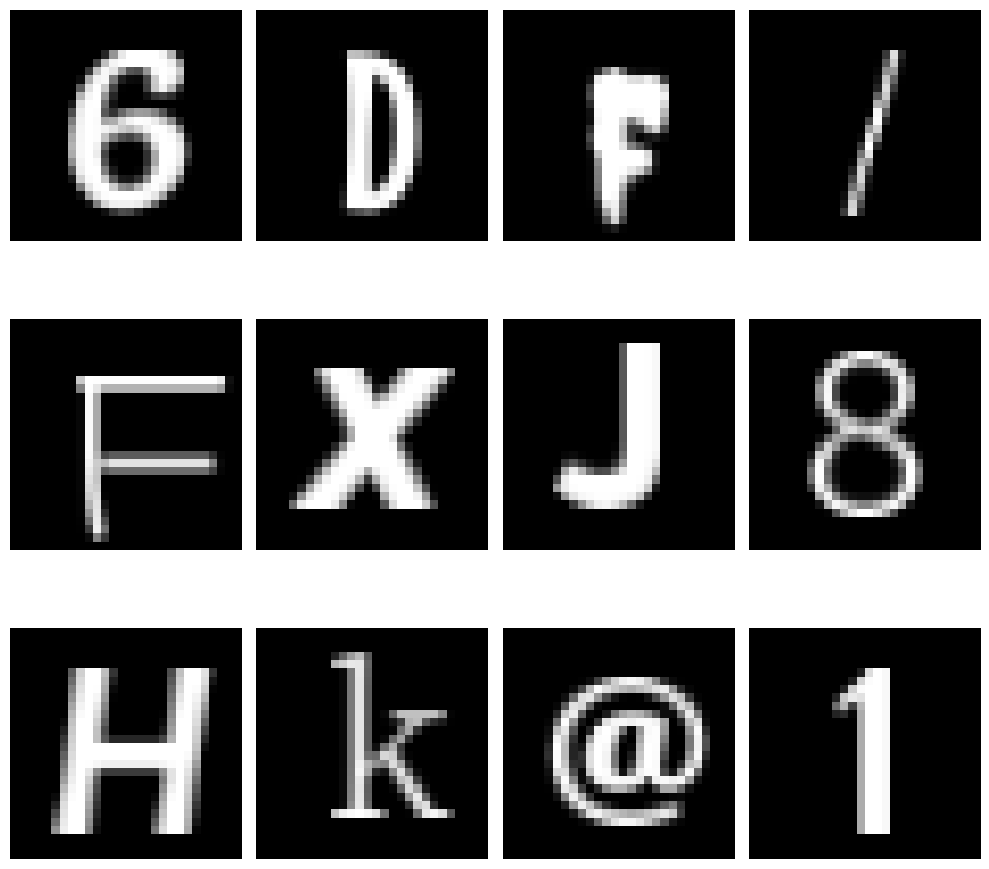

In [ ]:
x_images = X.reshape(-1,28,28)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))
axs = axs.flatten()

for img, ax in zip(x_images[:12], axs):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Dataset Overview and Model Architecture

### Dataset Composition

The dataset encompasses a diverse range of characters, including:
- Uppercase letters (A-Z)
- Lowercase letters (a-z)
- Numerals (0-9)
- Special characters (e.g., `@`, `=`)

### Objective

In this notebook, we aim to classify images from the TMNIST dataset using a Convolutional Neural Network (CNN). CNNs are renowned for their efficacy in image classification tasks due to their proficiency in pattern recognition, applicable in various domains like facial recognition, autonomous vehicles, and the fashion industry.

### Model Framework and Architecture

We will employ the Keras library with a TensorFlow backend to construct a 2D CNN tailored for digit recognition. The development process includes:

- **Preparing the dataset**: Formatting and normalizing the data to ensure it's suitable for use in our CNN.
- **Building the model**: Assembling the layers to form the CNN architecture.
- **Compiling the model**: Setting up the model with appropriate loss functions, optimizers, and metrics.
- **Training and evaluating the model**: Running the dataset through the model to learn and then assessing its performance.

#### Architectural Details

The CNN will have the following structure:

- **Feature Extraction Front End**:
  - **Convolutional Layers**: Two layers, each employing multiple filters to extract varied features from the input images, like straight lines, curves, and circles.
  - **Pooling Layer**: Reduces dimensionality of the data after convolution, retaining significant features while discarding irrelevant details.

- **Classification Back End**:
  - **Fully Connected Layer**: Integrates features from the convolutional and pooling layers to begin the classification process.
  - **Softmax Layer**: Outputs probabilities for each class, facilitating the final digit recognition task.

This architecture is designed to systematically identify and classify patterns within the TMNIST images, leading to accurate digit recognition.


## Understanding CNN Hyperparameters

Having discussed the various layers constituting a Convolutional Neural Network (CNN), we now shift focus to the hyperparameters that influence the output dimensions. These parameters play a crucial role in shaping the network's learning capabilities and performance.

### Key Hyperparameters

1. **Depth**
   - Represents the number of filters in a convolution layer.
   - Each filter detects different features from the input image, so more filters can capture more complex patterns.

2. **Stride**
   - Dictates the movement of the filter across the image.
   - A stride of 1 moves the filter one pixel at a time, while a stride of 2 moves it two pixels at a time, and so on.
   - Affects the size of the output feature map: larger strides result in smaller output dimensions.

3. **Padding**
   - Involves adding zeros around the perimeter of the input image before applying the convolution operation.
   - Helps maintain the spatial dimensions of the output, allowing the network to better learn and retain spatial hierarchies in the input data.
   - Can be viewed as enclosing the image in a zero-valued border, which ensures that the edge information is not lost during convolution.

### Impact on Output Size

These hyperparameters are essential for controlling the output size of the convolution layers. By adjusting the depth, stride, and padding, one can fine-tune the network to better capture the intricacies of the input data, ensuring that the model is neither too complex (leading to overfitting) nor too simplistic (resulting in underfitting).

In summary, understanding and carefully setting these hyperparameters allows for the optimization of the CNN architecture, balancing between capturing detailed features and maintaining computational efficiency.


## Hyperparameter Compatibility and Layer Transformation in CNNs

### Hyperparameter Compatibility

To ensure the effective operation of a CNN, the hyperparameters must align correctly with the input dimensions of the pooling layer. This alignment can be verified through the following equation:

$$
\frac{W - F + 2P}{S} + 1
$$

where:
- \(W\) is the size of the input volume,
- \(F\) represents the neuron's dimension in the convolutional layer,
- \(S\) stands for the stride length, and
- \(P\) denotes the padding amount.

A result that is an integer from this calculation signifies that the chosen hyperparameters are in harmony, ensuring the network functions as intended.

### Flatten and Dense Layers Transformation

The transformation process within CNNs involves Flatten and Dense layers, which are crucial for preparing the feature maps for classification. Specifically:

- The **Flatten layer** takes a multi-dimensional layer (e.g., a \(10 \times 10 \times 2\) matrix) and transforms it into a one-dimensional array, resulting in 200 units in this case.
- The **Dense layers** then utilize this flattened output, applying further classification processes to derive the final predictions.

### Activation Functions

CNNs employ the same activation functions as Dense Neural Networks. These functions are integral to the network, introducing non-linearity to the model and enabling it to learn complex patterns in the data.

In essence, understanding the relationship between hyperparameters and layer inputs, along with the role of Flatten and Dense layers, is crucial for crafting effective CNN architectures. These elements together facilitate the accurate classification of input data.


**Spliting the dataset into training and testing sets, with an 80-20 split**

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

**Shape of training data**

In [ ]:

print('X:Train, Test data shape: {}, {}'.format(X_train.shape, X_test.shape))
print('Y:Train, Test data shape: {}, {}'.format(y_train.shape, y_test.shape))


X:Train, Test data shape: (219274, 784), (54819, 784)
Y:Train, Test data shape: (219274, 1), (54819, 1)


**Data Preprocessing:Preparing the Training and Testing Dataset**

## Importance of Data Preprocessing in Deep Learning

Data preprocessing is a critical phase in preparing datasets for training and testing in deep learning models. Its significance stems from several key aspects:

### 1. Normalization

- **Purpose**: Normalization adjusts data to a consistent scale, crucial for enhancing the model's training convergence rate.
- **Benefit**: It allows the model to efficiently learn patterns, facilitating faster and more stable training.

### 2. Feature Extraction

- **Purpose**: To identify and retain only those features that are pertinent to the model's learning process, while eliminating redundancy.
- **Benefit**: Streamlines the training process by focusing on relevant data, leading to improved model accuracy and performance.

### 3. Handling Missing Data

- **Purpose**: Addresses the issue of incomplete datasets by filling in or omitting missing values.
- **Benefit**: Ensures the model has a complete and coherent dataset to learn from, which is crucial for accurate predictions.

### 4. Reducing Noise

- **Purpose**: Involves techniques like blurring or sharpening in image processing to clarify or remove irrelevant details.
- **Benefit**: Enhances the quality of the input data, leading to more precise model outputs.

### 5. Data Augmentation

- **Purpose**: Increases the diversity and quantity of training data through various transformations like rotation, scaling, and flipping.
- **Benefit**: Boosts the model's ability to generalize and reduces the likelihood of overfitting by exposing it to a broader range of data scenarios.

**In Summary:**

Data preprocessing not only refines the input data for optimal model training but also plays a pivotal role in enhancing the model's learning efficiency, accuracy, and robustness against overfitting. This stage sets the foundation for a deep learning model to perform effectively, making it an indispensable part of the machine learning pipeline.


**Normalize the dataset to values between 0 and 1**

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0


**Encode y values**

In [ ]:

char_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = char_enc.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = char_enc.transform(y_test.values.reshape(-1, 1))


**Reshaping the input data**

In [ ]:
new_shape = (-1, 28, 28)
X_train_norm = np.reshape(X_train.values, new_shape)
X_test_norm = np.reshape(X_test.values, new_shape)


# **Neural Network CNN Model Definition**

The purpose of this project is to demonstrate the effectiveness of using CNNs for image classification tasks. The TMNIST dataset consists of a variety of uppercase and lowercase letters, digits, and special characters in the English language. The dataset needs to be preprocessed before being used for training the CNN model. The data is split into training and testing sets, and the pixel values are normalized to a range of 0-1 to make it suitable for use in the neural network.

The CNN architecture is designed to take advantage of the spatial correlation between pixels in an image. Convolutional layers apply a set of filters to the input image to produce feature maps that highlight important aspects of the image. Pooling layers are used to reduce the spatial size of the feature maps while preserving important information. The fully connected layers at the end of the network perform the classification task by using the extracted features to make predictions.

The model is trained on the training dataset and evaluated on the testing dataset to determine its accuracy. The goal is to achieve an accuracy of greater than 96% on the testing set. The model's performance is visualized using a confusion matrix and classification report. Finally, the model is used to predict the character on a test image and checked for accuracy by comparing it with the actual character.

**3 layers Basic Neural Network Model**

This is a basic 3-layer neural network model with an input layer, a hidden layer for processing the input data, and an output layer for producing the final prediction. It is commonly used for classification and regression tasks, and its performance is dependent on the number of neurons in the hidden layer, the activation function used, and the optimization algorithm.

In [ ]:
#Defining the model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_of_unique_chars, activation='softmax')
])
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 94)                3102      
                                                                 
Total params: 474814 (1.81 MB)
Trainable params: 474814 (1.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Fitting the basic model**

In [ ]:
model_history = model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=2, batch_size=128)

Epoch 1/20
1714/1714 - 22s - loss: 0.8024 - accuracy: 0.7888 - val_loss: 0.4954 - val_accuracy: 0.8511 - 22s/epoch - 13ms/step
Epoch 2/20
1714/1714 - 21s - loss: 0.4391 - accuracy: 0.8646 - val_loss: 0.4233 - val_accuracy: 0.8647 - 21s/epoch - 12ms/step
Epoch 3/20
1714/1714 - 21s - loss: 0.3715 - accuracy: 0.8809 - val_loss: 0.3977 - val_accuracy: 0.8738 - 21s/epoch - 12ms/step
Epoch 4/20
1714/1714 - 19s - loss: 0.3271 - accuracy: 0.8920 - val_loss: 0.3644 - val_accuracy: 0.8821 - 19s/epoch - 11ms/step
Epoch 5/20
1714/1714 - 20s - loss: 0.2951 - accuracy: 0.9008 - val_loss: 0.3372 - val_accuracy: 0.8952 - 20s/epoch - 12ms/step
Epoch 6/20
1714/1714 - 21s - loss: 0.2676 - accuracy: 0.9089 - val_loss: 0.3357 - val_accuracy: 0.8958 - 21s/epoch - 12ms/step
Epoch 7/20
1714/1714 - 20s - loss: 0.2461 - accuracy: 0.9145 - val_loss: 0.3210 - val_accuracy: 0.9016 - 20s/epoch - 12ms/step
Epoch 8/20
1714/1714 - 21s - loss: 0.2292 - accuracy: 0.9199 - val_loss: 0.3237 - val_accuracy: 0.9045 - 21s/ep

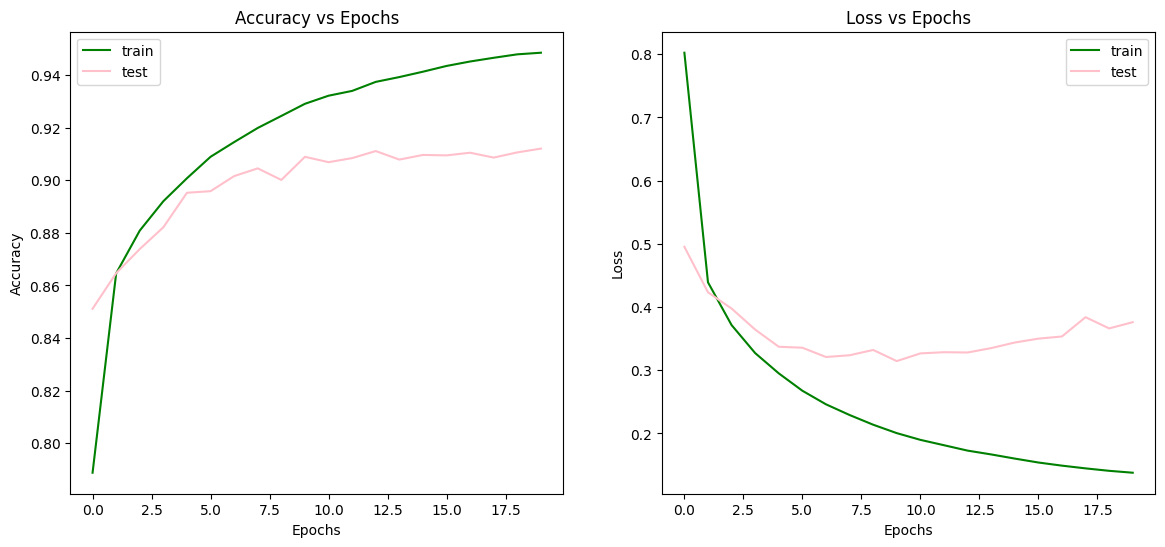

In [ ]:
# Plotting Results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

epochs = np.arange(20)

# Plot accuracy vs epochs
axs[0].set_title('Accuracy vs Epochs')
axs[0].plot(epochs, model_history.history['accuracy'], color='green', label='train')
axs[0].plot(epochs, model_history.history['val_accuracy'], color='pink', label='test')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss vs epochs
axs[1].set_title('Loss vs Epochs')
axs[1].plot(epochs, model_history.history['loss'], color='green', label='train')
axs[1].plot(epochs, model_history.history['val_loss'], color='pink', label='test')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()


**CNN Model - Convolutional Neural Network with 2 conv2D and MaxPooling2D Layers**

In [ ]:
cnn_model = Sequential([
    Conv2D(128, (5, 5), activation='relu', input_shape=(28, 28,1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_of_unique_chars, activation='softmax')
])
opt = Adam()
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

**Normalization of data for CNN model**

In [ ]:
X_train_norm = np.expand_dims(X_train_norm, axis=-1)
X_test_norm = np.expand_dims(X_test_norm, axis=-1)


**Model fitting**

In [ ]:
model_history2=cnn_model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=2,batch_size=128)

Epoch 1/20
1714/1714 - 476s - loss: 0.7599 - accuracy: 0.7942 - val_loss: 0.4375 - val_accuracy: 0.8628 - 476s/epoch - 278ms/step
Epoch 2/20
1714/1714 - 468s - loss: 0.3400 - accuracy: 0.8969 - val_loss: 0.3183 - val_accuracy: 0.9031 - 468s/epoch - 273ms/step
Epoch 3/20
1714/1714 - 482s - loss: 0.2718 - accuracy: 0.9166 - val_loss: 0.2645 - val_accuracy: 0.9205 - 482s/epoch - 281ms/step
Epoch 4/20
1714/1714 - 480s - loss: 0.2361 - accuracy: 0.9261 - val_loss: 0.2370 - val_accuracy: 0.9270 - 480s/epoch - 280ms/step
Epoch 5/20
1714/1714 - 465s - loss: 0.2134 - accuracy: 0.9315 - val_loss: 0.2349 - val_accuracy: 0.9269 - 465s/epoch - 271ms/step
Epoch 6/20
1714/1714 - 469s - loss: 0.1959 - accuracy: 0.9357 - val_loss: 0.2287 - val_accuracy: 0.9279 - 469s/epoch - 273ms/step
Epoch 7/20
1714/1714 - 475s - loss: 0.1817 - accuracy: 0.9396 - val_loss: 0.2225 - val_accuracy: 0.9289 - 475s/epoch - 277ms/step
Epoch 8/20
1714/1714 - 477s - loss: 0.1694 - accuracy: 0.9428 - val_loss: 0.2222 - val_acc

**Plotting the results**

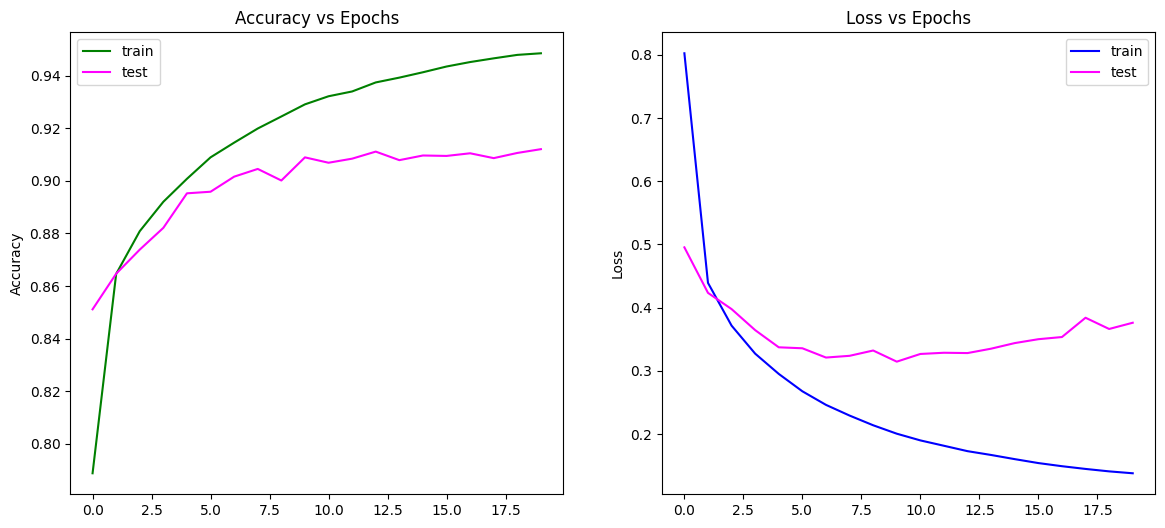

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

epochs = np.arange(20)

axs[0].set_title('Accuracy vs Epochs')
axs[0].plot(epochs, model_history.history['accuracy'], label='train', color='green')
axs[0].plot(epochs, model_history.history['val_accuracy'], label='test', color='magenta')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].set_title('Loss vs Epochs')
axs[1].plot(epochs, model_history.history['loss'], label='train', color='blue')
axs[1].plot(epochs, model_history.history['val_loss'], label='test', color='magenta')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()


# **CONCLUSION**

* **The dataset includes a large number of images (281,000), which are used for
  training machine learning models for character recognition.**

* The model achieved a final **accuracy** of **96.18%** on the **training set**.



The data is preprocessed by excluding non-numeric columns, converting columns to numeric while coercing errors to NaN, handling NaNs by filling them with zeros, and normalizing pixel values by scaling them between 0 and 1

In conclusion, the comparative study of a basic 3-layer neural network and a CNN model on classification tasks reveals several key points:

- **Basic Neural Network Performance**:
  - Showed consistent improvement over 20 epochs.
  - Achieved final training and validation accuracies of approximately 94.85% and 91.20%, respectively.
  

- **CNN Model Performance**:
  - Demonstrated superior accuracy and stability in loss values.
  - Reached higher training and validation accuracies of about 96.18% and 93.41%, respectively.
  - Utilized convolutional and pooling layers effectively for enhanced feature extraction and learning.

- **Importance of Architecture**:
  - The comparison highlights the significance of choosing the right architecture for neural network performance.
  - CNN’s ability to handle spatial hierarchies in data results in better management of complex patterns, outperforming the basic neural network model.

The findings underscore the necessity of monitoring both accuracy and loss metrics during training to mitigate overfitting and enhance the model’s generalization capabilities. Ultimately, the choice of neural network architecture significantly influences the model's performance and effectiveness in addressing classification challenges.


# **CITATIONS**

* https://www.kaggle.com/datasets/nikbearbrown/tmnist-alphabet-94-characters
* https://www.kaggle.com/datasets/nikbearbrown/
* https://chat.openai.com/
* https://www.kaggle.com/code/patilriya/tmnist-alphabet-above-90-accuracy
* https://www.kaggle.com/datasets/nikbearbrown/tmnist-alphabet-94-characters/code




# **LICENSE**

MIT License

Copyright (c) 2024 sakhareni

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.